# Visualizing results

In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from src.utils import get_metrics

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2023-08-28 15:21:15.854241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Summary table

In [20]:
folder = './presentation/experiments/astromer_2/results_2/normal/'
exp_folders = glob.glob(os.path.join(folder, '*', 'pretraining'))

In [21]:
metric_names= ['epoch_loss', 'epoch_r_square', 'epoch_rmse', 'epoch_bce', 'epoch_acc']

rows = []
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'logs')
    
    with open(config_path, 'r') as f:
        config = toml.load(f)
    
    try:
        val_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name='epoch_loss')
        best_epoch = val_metrics['value'].astype(float).argmin() 

        for index, metric in enumerate(metric_names):
            try:
                train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
                valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)

                config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
                config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)        
            except:
                continue
        rows.append(pd.Series(config))
    except:
        continue
results = pd.concat(rows, axis=1).T
results.columns

Index(['exp_name', 'data', 'gpu', 'debug', 'encoder_mode', 'layers', 'nh',
       'hdim', 'pe_dim', 'mixer', 'dropout', 'avg_layers', 'lr', 'bs',
       'patience', 'epochs', 'ws', 'optimizer', 'off_nsp', 'probed', 'rs',
       'nsp_prob', 'rmse_factor', 'epoch_loss', 'epoch_loss_val',
       'epoch_r_square', 'epoch_r_square_val'],
      dtype='object')

In [24]:
def format_label(x):
    label = 'Enc: {}\n Layers: {}\n Mixer: {}\n Dropout: {:.2f}\n RMSE a: {}\n AvgOut: {}\n Probed: {:.2f}'.format(x['encoder_mode'], x['layers'], 
                                                             x['mixer'], x['dropout'], x['rmse_factor'], 
                                                             x['avg_layers'], x['probed'])
    return label

results['tickname'] = results.apply(lambda x: format_label(x), 1) 
results

,exp_name,data,gpu,debug,encoder_mode,layers,nh,hdim,pe_dim,mixer,...,off_nsp,probed,rs,nsp_prob,rmse_factor,epoch_loss,epoch_loss_val,epoch_r_square,epoch_r_square_val,tickname
0,normal,./data/records/macho_clean,1,False,normal,1,4,64,256,64,...,True,0.4,0.2,0.5,1.0,0.012,0.009,0.436,0.525,Enc: normal\n Layers: 1\n Mixer: 64\n Dropout:...
1,normal,./data/records/macho_clean,0,False,normal,1,4,64,256,64,...,True,0.2,0.2,0.5,1.0,0.013,0.01,0.381,0.527,Enc: normal\n Layers: 1\n Mixer: 64\n Dropout:...


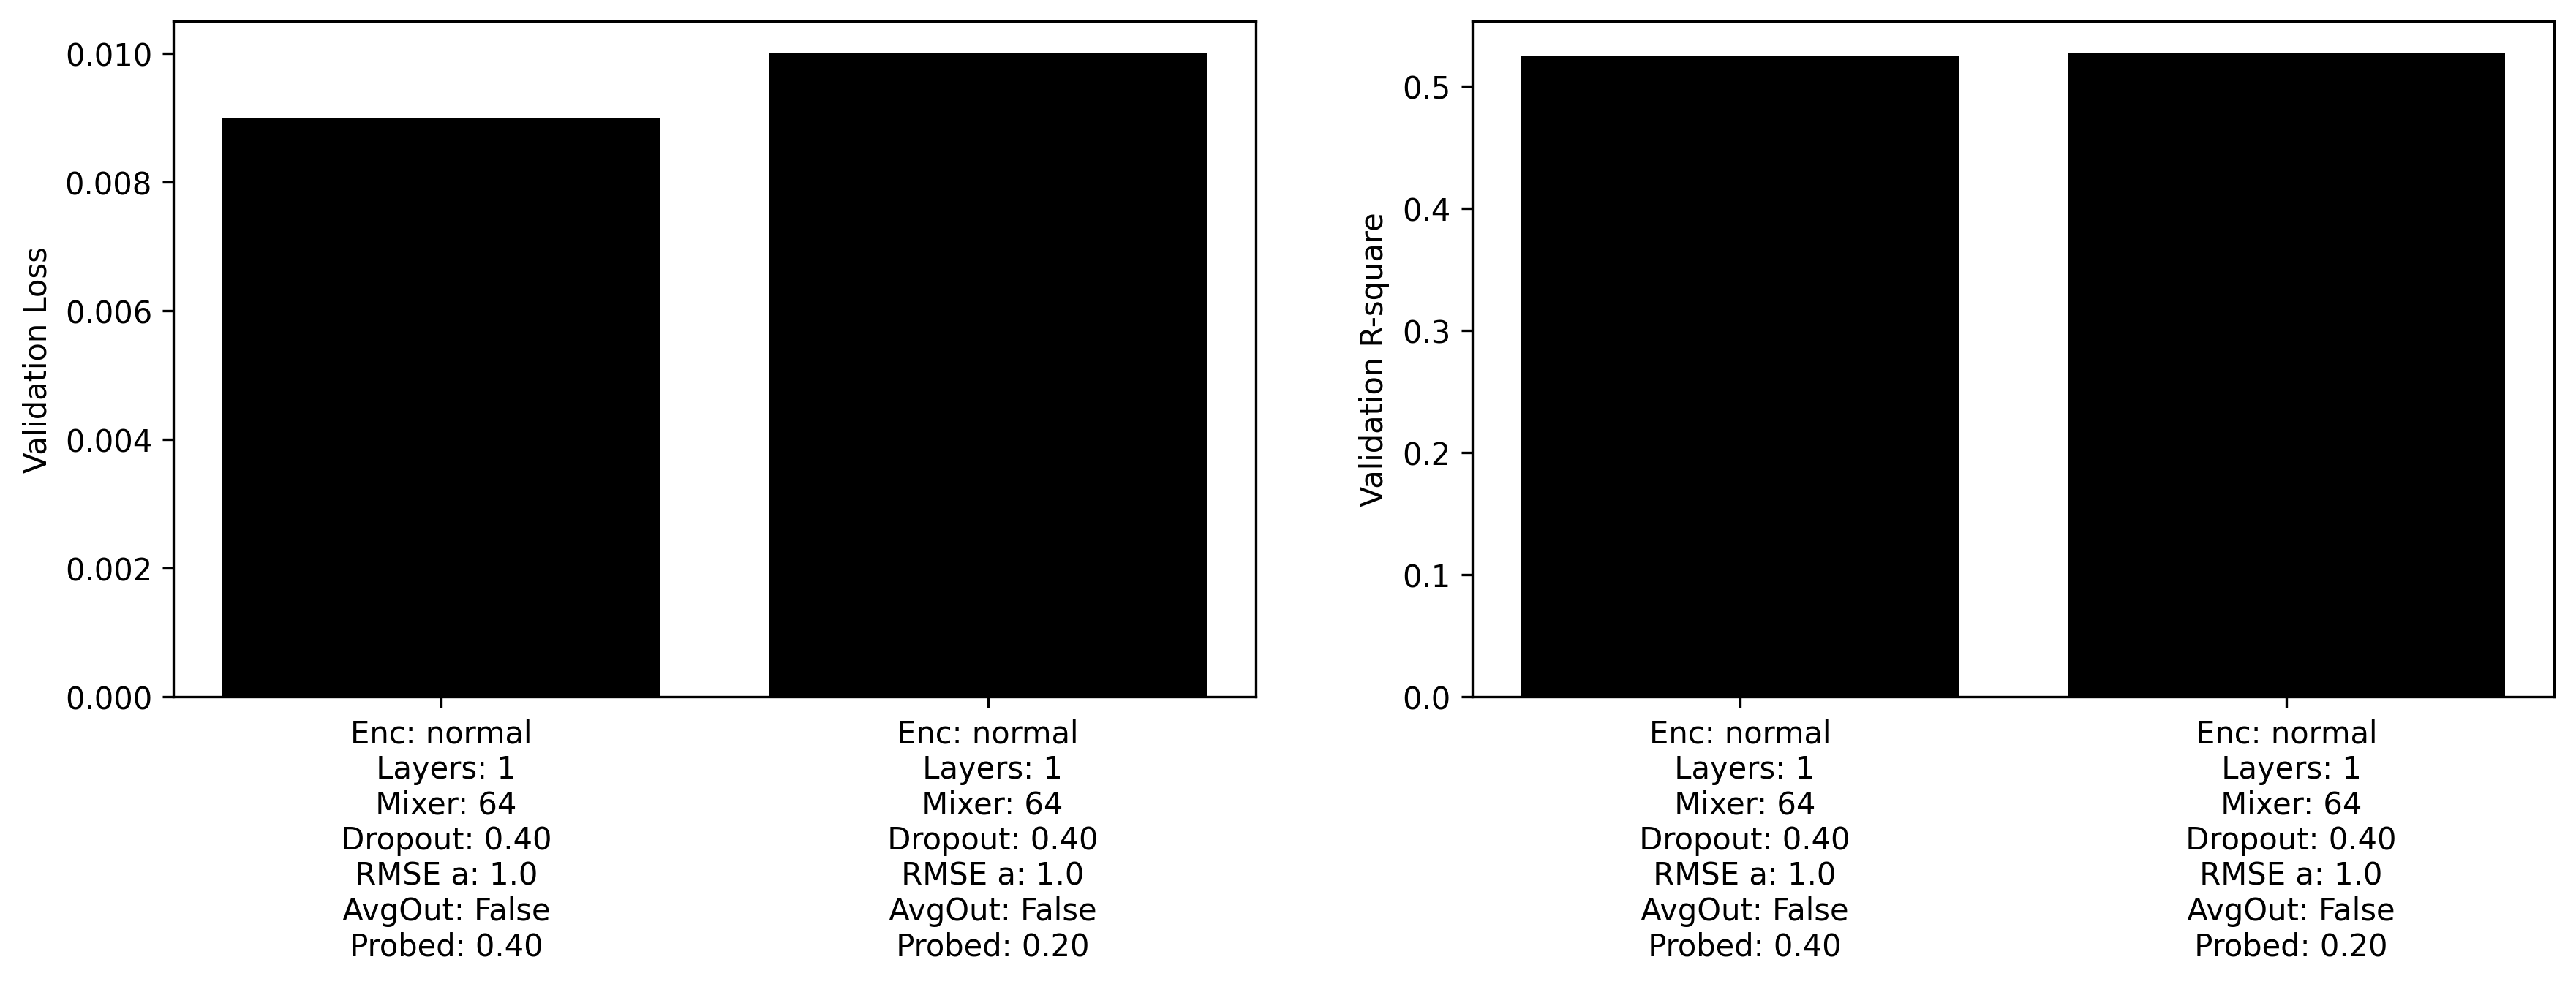

In [25]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'hspace': 0., 'wspace': 0.2}, dpi=300, figsize=(14, 4))
axes = axes.flatten()
labels_name = {
    'epoch_loss_val': 'Validation Loss',
    'epoch_rmse_val': 'Validation RMSE',
    'epoch_r_square_val': 'Validation R-square',
    'epoch_acc': 'Validation Accuracy',
    'epoch_bce': 'Validation Binary \n Cross-Entropy',
    }

for i, column in enumerate(['epoch_loss_val', 'epoch_r_square_val']):
    
    if 'loss' in column and 'epoch_bce' in column:
        results['epoch_bce_val'][results['epoch_bce_val'].isna()]  = 0.
        y = results[column] - results['epoch_bce_val']/2
    else:
        y = results[column]
        
    axes[i].bar(results['tickname'], y, color='k')
    axes[i].set_ylabel(labels_name[column])

## Testing results

In [13]:
import toml
root = './presentation/experiments/astromer_2/results/best/'

x_labels = []
rmse_values = []
r2_values = []
for folder in os.listdir(root):
    try:
        with open(os.path.join(root, folder, 'pretraining', 'config.toml'), 'r') as h:
            config = toml.load(h)
            info = format_label(config)
        with open(os.path.join(root, folder, 'pretraining', 'metrics.toml'), 'r') as h:
            metrics = toml.load(h)
            x_labels.append(info)
            rmse_values.append(metrics['test_rmse'])
            r2_values.append(metrics['test_r2'])
    except Exception as e:
        continue

Text(0, 0.5, 'Test R-square')

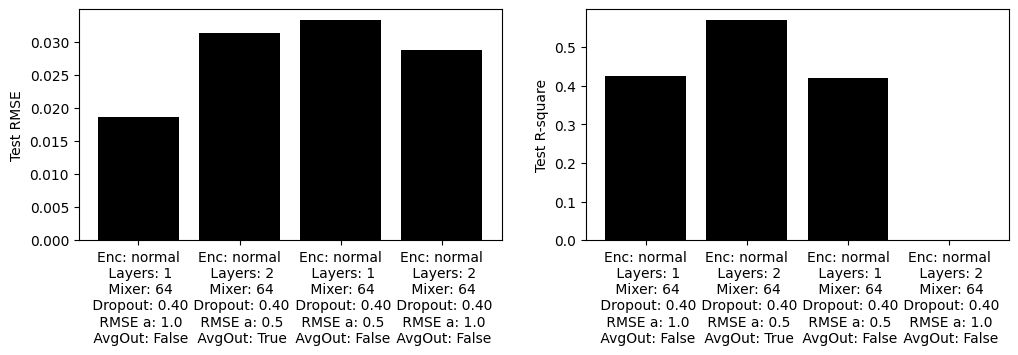

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].bar(x_labels, rmse_values, color='k')
axes[1].bar(x_labels, r2_values, color='k')
axes[0].set_ylabel('Test RMSE')
axes[1].set_ylabel('Test R-square')

### Visualize learning curves

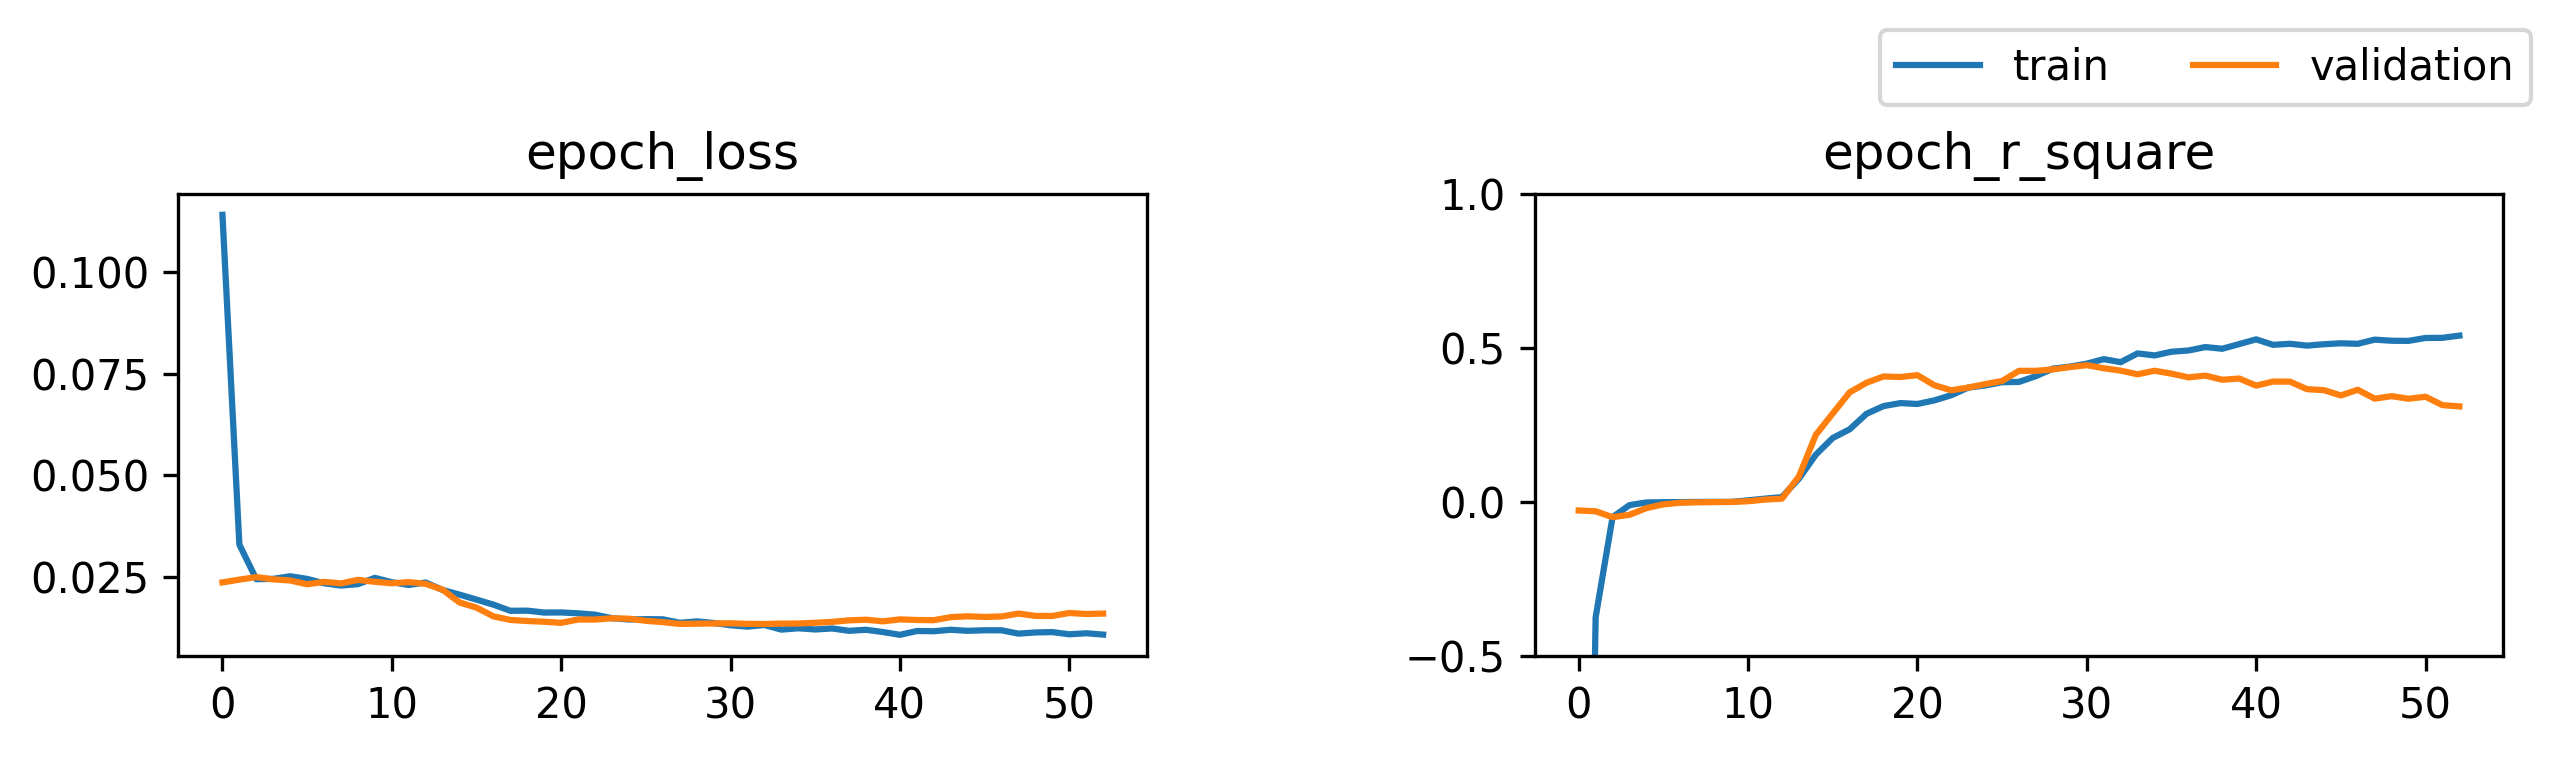

In [16]:
logs_path = './presentation/experiments/astromer_2/results/best/2023-07-27_14-23-47/'

# metric_names= ['epoch_loss', 'epoch_rmse', 'epoch_r_square', 'epoch_bce', 'epoch_acc']
metric_names= ['epoch_loss', 'epoch_r_square']
fig, axes = plt.subplots(1, 2, figsize=(10,2), dpi=300, 
                        gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
for index, metric_name in enumerate(metric_names):
    train_metrics = get_metrics(os.path.join(logs_path, 'pretraining/logs/train'), metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(logs_path, 'pretraining/logs/validation'), metric_name=metric_name)
    
    axes[index].plot(train_metrics['value'], label='train')
    axes[index].plot(valid_metrics['value'], label='validation')
    axes[index].set_title(metric_name)

axes[1].set_ylim(-0.5, 1)
axes[-1].legend(bbox_to_anchor=(1.05, 1.4), ncols=2)

### Classification results

In [3]:
astromer_0 = pd.read_csv('./presentation/experiments/astromer_0/backup/wandb_tables/downstream.csv')

In [40]:
summary = pd.read_csv('./presentation/experiments/astromer_2/results/clf_20.csv')
summary = summary[summary['State'] == 'finished']

In [75]:
def name_pt_model(folder_name):
    if folder_name == '2023-08-25_20-44-55':
        return 'clean'
    if folder_name == '2023-08-25_20-44-47':
        return 'paper'

alcock
atlas


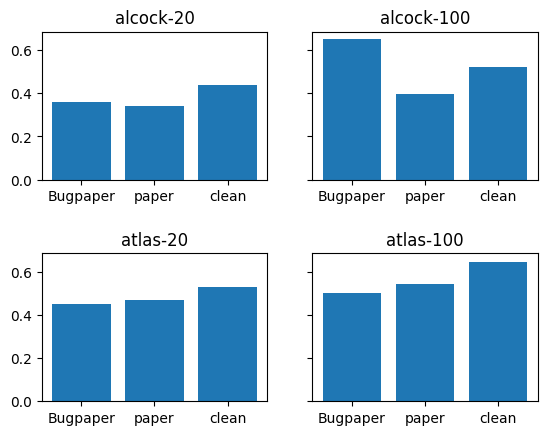

In [85]:
fig, axes = plt.subplots(2, 2, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}, sharey=True)
color_dict = ['darkred', 'darkgreen']
for i, (subdataset_name, subframe) in enumerate(summary.groupby('subdataset')):
    print(subdataset_name)
    offset = 0.
    subframe = subframe[subframe['clf_name'] == 'mlp_att']
    for j, (spc, subframe_2) in enumerate(subframe.groupby('spc')):    
        
        # ======
        astromer_old = pd.read_csv('./presentation/experiments/astromer_0/backup/errata/results/paper/{}/classification/metrics.csv'.format(subdataset_name))
        acc_old = astromer_old[(astromer_old['model'] == 'mlp_att') & \
                               (astromer_old['spc'] == spc) & \
                               (astromer_old['sci_case'] == 'b')][['test_f1']].mean().values[0]
        
        
        subgroups = subframe_2.groupby(['clf_name', 'pt_model'])
        metrics = subgroups[['clf_test_f1', 'clf_test_acc']].mean().reset_index()

        single = metrics[metrics['clf_name'] == 'mlp_att']
        values = list(single['clf_test_f1'].values)
        values = [acc_old] + values
        
        xticks = [name_pt_model(x.split('/')[0]) for x in single['pt_model'].values]
        xticks = ['Bugpaper'] + xticks

        axes[i][j].bar(xticks, values)
        axes[i][j].set_title('{}-{}'.format(subdataset_name, spc))
        offset+=0.2
        


In [ ]:
QK 